In [806]:
import sys
sys.path.append("../nullitoutsrc")
sys.path.append("../data/embeddings")
import classifier
import debias
import debias_original
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
from matplotlib import pyplot as plt

In [807]:
from importlib import reload
reload(debias)
reload(debias_original)

<module 'debias_original' from '../nullitoutsrc\\debias_original.py'>

### Load data, project on subspace and save methods

In [3]:
def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.key_to_index.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    # 
    vecs = []
    for w in word_list:
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):

    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        # for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):
        for i, (v,w) in enumerate(zip(vecs, words)):
            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

### Load vectors

In [4]:

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")

# only gendered vectors

model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")


In [5]:
num_vectors_per_class = 7500
gender_direction = model["he"]-model["she"] 
gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)



n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)

In [6]:
print("TOP Feminine")
print(fem_words[:50])
print("-------------------------------")
print("TOP Masculine")
print(masc_words[:50])
print("-------------------------------")
print(neut_words[:50])

TOP Feminine
('nichole', 'ftv', 'renee', 'sophie', 'christina', 'marie', 'pregnant', 'nicole', 'samantha', 'denise', 'sassy', 'madeline', 'alicia', 'lynette', 'xoxo', 'melanie', 'michelle', 'missy', 'kimberly', 'melissa', 'kayla', 'angelina', 'kristin', 'jennifer', 'emma', 'katie', 'pregnancy', 'jessica', 'heidi', 'tina', 'mandy', 'erika', 'maggie', 'shes', 'elaine', 'julie', 'vanessa', 'actress', 'leanne', 'kristina', 'faye', 'alexandra', 'tanya', 'fiona', 'rebecca', 'cassie', 'cindy', 'janice', 'danielle', 'ballerina')
-------------------------------
TOP Masculine
('drafted', 'qb', 'soriano', 'himself', 'cardinals', 'giants', 'he', 'bullpen', 'sabean', 'jagr', 'muhammad', 'alou', 'rangers', 'defensive', 'draft', 'belichick', 'rookie', 'ratzinger', 'obp', 'santonio', 'muhammed', 'yankees', 'outfielder', 'preached', 'playmaker', 'lineman', 'offensive', 'wr', 'steelers', 'redskins', 'rushers', 'his', 'punter', 'anquan', 'boldin', 'bochy', 'caesarea', 'nfl', 'umenyiora', 'laurinaitis', '

In [7]:
n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))
                                                  
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)                                                  

### Perform train-dev-test split

In [8]:
# X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))
y = np.concatenate((y_masc, y_fem))
# y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 7350; Dev size: 3150; Test size: 4500


### Check how many components the PCA finds in the data

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA()
pca.fit(X_train)
eigen_values = pca.explained_variance_

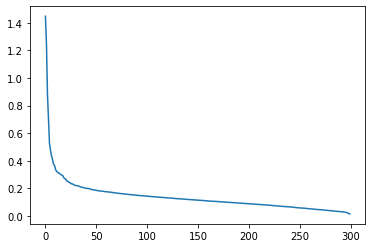

In [10]:
eigen_values = -np.sort(-eigen_values)
plt.plot(eigen_values)
plt.show()

In [ ]:
pca.components_

In [114]:
np.savetxt("eigen_values.csv", eigen_values.reshape((-1,1)))

### Train Test slpits

In [9]:
def perform_train_dev_split_3(fem_vecs, masc_vecs, neut_vecs , seed=0):

    X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
    y_masc = np.ones(masc_vecs.shape[0], dtype = int)
    y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
    y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
    y = np.concatenate((y_masc, y_fem, y_neut))
        
    X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state=seed)
    X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state=seed)
    # print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

def perform_train_dev_split_2(fem_vecs, masc_vecs , seed=0):
    X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
    y_masc = np.ones(masc_vecs.shape[0], dtype = int)
    y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
    y = np.concatenate((y_masc, y_fem))
        
    X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state=seed)
    X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state=seed)
    # print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))
    return X_train, X_dev, X_test, Y_train, Y_dev, Y_test

In [10]:
X3_train, X3_dev, X3_test, Y3_train, Y3_dev, Y3_test = perform_train_dev_split_3(fem_vecs, masc_vecs, neut_vecs, seed=0)

### Debias 2 classes

In [1564]:
gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P, rowspace_projs, Ws, accs = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)



iteration: 34, accuracy: 0.5101587301587301: 100%|██████████| 35/35 [00:11<00:00,  3.10it/s] 


### Debias using 3 classes

In [960]:
from importlib import reload
reload(debias)

<module 'debias' from '../nullitoutsrc\\debias.py'>

In [1271]:
gender_clf = LinearSVC

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc

n = 36
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P3, rowspace_projs3, Ws3, accs3 = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X3_train, Y3_train, X3_dev, Y3_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 35, accuracy: 0.31447767663632425: 100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


In [16]:
np.save("INLP_P_35.np", P)

In [22]:
#The mean vector of all masc_vectors and fem_vecs
masc_mean = np.mean(masc_vecs, axis=0)
fem_mean = np.mean(fem_vecs, axis=0)
v = fem_mean - masc_mean
v = v.reshape(1,-1)



### Projecting the means onto each other

In [811]:
# Get the masc and fem vectors among the training set
def separate_fem_masc_neut(X_train, Y_train):
    masc_mask = Y_train == 1
    mascY_train = Y_train[masc_mask]
    mascX_train = X_train[masc_mask]

    fem_mask = Y_train == 0
    femY_train = Y_train[fem_mask]
    femX_train = X_train[fem_mask]

    neut_mask = Y_train == -1
    neutY_train = Y_train[neut_mask]
    neutX_train = X_train[neut_mask]
    return femX_train, mascX_train, neutX_train   

def get_projection_means_onto_eachother(fem, masc, neut):
    masc_mean = np.mean(masc, axis=0)
    fem_mean = np.mean(fem, axis=0)
    neut_mean = np.mean(neut, axis=0)
    v_means_1 = neut_mean - masc_mean
    v_means_2 = neut_mean - fem_mean

    v_means_1 = v_means_1/np.linalg.norm(v_means_1)
    v_means_2 = v_means_2/np.linalg.norm(v_means_2)

    v_means_1 = v_means_1.reshape(1,-1)
    v_means_2 = v_means_2.reshape(1,-1)

    W = [v_means_1, v_means_2]

    P, rowspace_projs = debias.debias_by_specific_directions(W, input_dim=300)
    return P

def get_projection_vectors_means_onto_eachother(fem, masc, neut):
    masc_mean = np.mean(masc, axis=0)
    fem_mean = np.mean(fem, axis=0)
    
    if neut.shape[0] == 0:
        v_means = fem_mean - masc_mean
        v_means = v_means.reshape(1,-1)
        
        W = [v_means]
    
    else:
        neut_mean = np.mean(neut, axis=0)
        v_means_1 = neut_mean - masc_mean
        v_means_2 = neut_mean - fem_mean

        v_means_1 = v_means_1/np.linalg.norm(v_means_1)
        v_means_2 = v_means_2/np.linalg.norm(v_means_2)

        v_means_1 = v_means_1.reshape(1,-1)
        v_means_2 = v_means_2.reshape(1,-1)
        W = [v_means_1, v_means_2]
    return W


In [435]:
# X3_train, X3_dev, X3_test, Y3_train, Y3_dev, Y3_test = perform_train_dev_split_3(fem_vecs, masc_vecs, neut_vecs, seed=0)
fem3_train, masc3_train, neut3_train = separate_fem_masc_neut(X3_train, Y3_train)
P_mean_3 = get_projection_means_onto_eachother(fem3_train, masc3_train, neut3_train)
X3_dev_cleaned = (P_mean_3.dot(X3_dev.T)).T
X3_train_cleaned_mean = P_mean_3.dot(X3_train.T).T
X3_test_cleaned_mean = P_mean_3.dot(X3_test.T).T

linear_clf = LinearSVC(dual=False, max_iter = 1500)
linear_clf.fit(X3_train_cleaned_mean, Y3_train)
acc_mean = linear_clf.score(X3_dev_cleaned, Y3_dev)
print(f"The accuracy of Linear SVC after projecting means on top of each other is {round(acc_mean*100, 2)}%.")

The accuracy of Linear SVC after projecting means on top of each other is 34.94%.


In [14]:
# np.save("masc_X_train.npy", mascX_train)
# np.save("fem_X_train.npy", femX_train)
np.save("P_means_neut.glove.dim=300.npy", P_mean_3)

### Debias Iteratively by projecting means

In [1568]:
def debias_by_means(iterations, method, include_neut=False, random_state_start=100):
    N = None
    spliter = perform_train_dev_split_2
    if include_neut:
        N = neut_vecs   
        spliter = perform_train_dev_split_3     
    seeds = list(range(random_state_start, random_state_start+iterations))
    accuracy = []
    iters = []
    X_train, X_dev, X_test, Y_train, Y_dev, Y_test = spliter(fem_vecs, masc_vecs, N, seed=0)
    init_X_test, init_Y_test = X_test, Y_test
    fem_train, masc_train, neut_train = separate_fem_masc_neut(X_train, Y_train)
    linear_clf = LinearSVC(fit_intercept=False, class_weight=None, dual=False, max_iter = 1500, random_state=0)
    linear_clf.fit(X_train, Y_train)
    acc = linear_clf.score(X_dev, Y_dev)
    # print(f"The accuracy of Linear SVC after projecting means 0 times is {round(acc*100, 2)}%.")
    print("""<use name="mark/disk(sx)" pos="{} {}" size="1" stroke="CB dark blue"/>""".format(0, round(acc*100, 2)))
    accuracy.append(round(acc*100, 2))
    iters.append(0)
    W = []
    for i, s in enumerate(seeds):
        X_train, X_dev, X_test, Y_train, Y_dev, Y_test = spliter(fem_vecs, masc_vecs, N, seed=0)
        fem_train, masc_train, neut_train = separate_fem_masc_neut(X_train, Y_train)
        new_W = get_projection_vectors_means_onto_eachother(fem_train, masc_train, neut_train)
        W.extend(new_W)
        P_means, rowspace_projs = method.debias_by_specific_directions(W, input_dim=300)
        X_test_cleaned = P_means.dot(init_X_test.T).T
        X_train_cleaned_mean = P_means.dot(X_train.T).T

        linear_clf = LinearSVC(fit_intercept=False, class_weight=None, dual=False, max_iter = 1500, random_state=s)
        linear_clf.fit(X_train_cleaned_mean, Y_train)
        acc = linear_clf.score(X_test_cleaned, init_Y_test)
        accuracy.append(round(acc*100, 2))
        iters.append(i+1)
        # print(f"The accuracy of Linear SVC after projecting means {i+1} times is {round(acc*100, 2)}%.")
        print("""<use name="mark/disk(sx)" pos="{} {}" size="2" stroke="CB dark blue"/>""".format((i+1)*5, round(acc*100, 2)))
    P_means, rowspace_projs = method.debias_by_specific_directions(W, input_dim=300)
    return iters, accuracy, W, P_means
   

In [1569]:
iters, accuracy_means_one, W2_means_one, P2_means_one = debias_by_means(iterations=1, method = debias, include_neut=False)
# P2_means_one, rowspace_projs_means_2_one = debias.debias_by_specific_directions(W2_means_one, input_dim=300)

<use name="mark/disk(sx)" pos="0 100.0" size="1" stroke="CB dark blue"/>
<use name="mark/disk(sx)" pos="5 50.67" size="2" stroke="CB dark blue"/>


In [984]:
iters, accuracy_means_one, W3_means_one, P3_means_one = debias_by_means(iterations=1, method=debias, include_neut=True)
# P3_means_one, rowspace_projs_means_3_one = debias_original.debias_by_specific_directions(W3_means_one, input_dim=300)

<use name="mark/disk(sx)" pos="0 95.51" size="1" stroke="CB dark blue"/>
<use name="mark/disk(sx)" pos="5 34.06" size="2" stroke="CB dark blue"/>


In [ ]:
iters, accuracy3_means, W3_means = debias_by_means(iterations=35, include_neut=True)
P3_means, rowspace_projs_means_3 = debias.debias_by_specific_directions(W3_means, input_dim=300)

In [ ]:
for i, a in enumerate(accs):
    print("""<use name="mark/disk(sx)" pos="{} {}" size="2" stroke="CB dark orange"/>""".format(i*5 , round(a, 2)))

### Non-linear classifier

In [1437]:
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit((P3_means_one.dot(X3_train.T)).T, Y3_train)
print(nonlinear_clf.score((P3_means_one.dot(X3_dev.T)).T, Y3_dev))

0.8157780667533593


In [1438]:
print(nonlinear_clf.score((P3_means_one.dot(X3_test.T)).T, Y3_test))

0.8180852677894098


### MP + INLP

In [78]:
X3_train_cleaned_MP = (P3_means_one.dot(X3_train.T)).T

gender_clf = LinearSVC

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc

n = 34
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P_mp_inlp_3, rowspace_projs3, Ws_mp_inlp, accs3 = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X3_train_cleaned_MP, Y3_train, X3_dev, Y3_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 33, accuracy: 0.35332323013639316: 100%|██████████| 34/34 [00:30<00:00,  1.12it/s]


In [137]:
np.save("P3_mp_INLP.npy", P_mp_inlp_3)

### MP + Random INLP 

In [19]:
X3_train_cleaned_MP = (P3_means_one.dot(X3_train.T)).T
Y3_train_shuffled = Y3_train.copy()
Y3_dev_shuffled = Y3_dev.copy()
shuffle(Y3_train_shuffled)
shuffle(Y3_dev_shuffled)
gender_clf = LinearSVC

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc

n = 34
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P_mp_random_inlp_3, rowspace_projs_mp_random_3, Ws_mp_random_3, accs3 = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X3_train_cleaned_MP, Y3_train_shuffled, X3_dev, Y3_dev_shuffled,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 33, accuracy: 0.3279150411790204: 100%|██████████| 34/34 [00:29<00:00,  1.15it/s] 


### MP + least significant components

In [721]:
pca = PCA()
pca.fit(P3_means_one.dot(X3_train.T).T)
eigen_values = pca.explained_variance_

In [1039]:
least_significants = []
for i in range(33):
    least_significants.append(pca.components_[-(i+2)*3: -(i+1)*3])

In [1030]:
X3_train_cleaned_MP = p_new.dot(X3_train.T).T
gender_clf = LinearSVC

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
P_mp_least, rowspace_projs_mp_least = debias.debias_by_specific_directions(W3_means_one+least_significants, input_dim=300)

In [1034]:
print(weat_score(A, B, C, D, model, P_mp_least))
print(weat_score(A, B, E, F, model, P_mp_least))
print(weat_score(A, B, G, H, model, P_mp_least))


-0.1990127346614948
0.27485291216710794
0.07896089724712689


### MP + most significant components

In [1040]:
most_significants = []
for i in range(33):
    most_significants.append(pca.components_[(i)*3:(i+1)*3])

In [1031]:
X3_train_cleaned_MP = (P3_means_one.dot(X3_train.T)).T
gender_clf = LinearSVC

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
P_mp_most, rowspace_projs_mp_most = debias.debias_by_specific_directions(W3_means_one+most_significants, input_dim=300)

In [1035]:
print(weat_score(A, B, C, D, model, P_mp_most))
print(weat_score(A, B, E, F, model, P_mp_most))
print(weat_score(A, B, G, H, model, P_mp_most))

0.1729660580579818
0.19643898415955638
0.11007033983459066


### MP + random components

In [234]:
rs = []
w1 = []
w2 = []
w3 = []
for j in range(100):
    r = []
    for i in range(33):
        r.append(np.random.normal(0,1, 300).reshape((1,300)))

    rs.append(r)
    gender_clf = LinearSVC

    params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
    params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
    params = params_svc
    P_mp_rand_vec, rowspace_projs_mp_rand_vec = debias.debias_by_specific_directions(W3_means_one+r, input_dim=300)
    
    w1.append(weat_score(A, B, C, D, model, P_mp_rand_vec))
    w2.append(weat_score(A, B, E, F, model, P_mp_rand_vec))
    w3.append(weat_score(A, B, G, H, model, P_mp_rand_vec))

### MP + MP on half

In [225]:
def MP_random_half(X_train, Y_train, X_test, Y_test, iterations=35, random_state_start=100):
    fems, mascs, neuts = separate_fem_masc_neut(X_train, Y_train) 
    seeds = list(range(random_state_start, random_state_start+iterations-1))
    accuracy, iters, proj_vecs = [], [], []
    ipe_text = ""
    linear_clf = LinearSVC(fit_intercept=False, class_weight=None, dual=False, max_iter = 1500, random_state=0)
    linear_clf.fit(X_train, Y_train)
    acc = linear_clf.score(X_dev, Y_dev)
    print(f"The accuracy of Linear SVC after projecting means 0 times is {round(acc*100, 2)}%.")
    ipe_text+= """<use name="mark/disk(sx)" pos="{} {}" size="1" stroke="CB dark blue"/>\n""".format(0, round(acc*100, 2))
    accuracy.append(round(acc*100, 2))
    iters.append(0)
    new_W = get_projection_vectors_means_onto_eachother(fems, mascs, neuts)
    proj_vecs.extend(new_W)
    P_means, rowspace_projs = debias.debias_by_specific_directions(proj_vecs, input_dim=300)
    X_test_cleaned = P_means.dot(X_test.T).T
    cleaned_X = P_means.dot(X_train.T).T
    linear_clf = LinearSVC(fit_intercept=False, class_weight=None, dual=False, max_iter = 1500, random_state=seeds[0])
    linear_clf.fit(cleaned_X, Y_train)
    acc = linear_clf.score(X_test_cleaned, Y_test)
    accuracy.append(round(acc*100, 2))
    iters.append(1)
    print(f"The accuracy of Linear SVC after projecting means 0 times is {round(acc*100, 2)}%.")
    ipe_text+= """<use name="mark/disk(sx)" pos="{} {}" size="1" stroke="CB dark blue"/>\n""".format(0, round(acc*100, 2))
    for i, s in enumerate(seeds[1:]):
        f1, f2, y1, y2 = sklearn.model_selection.train_test_split(fems, [0]*fems.shape[0], test_size = 0.5)
        m1, m2, y1, y2 = sklearn.model_selection.train_test_split(mascs, [0]*mascs.shape[0], test_size = 0.5)
        n1, n2, y1, y2 = sklearn.model_selection.train_test_split(neuts, [0]*neuts.shape[0], test_size = 0.5)
        new_W = get_projection_vectors_means_onto_eachother(f1, m1, n1)
        proj_vecs.extend(new_W)
        P_means, rowspace_projs = debias.debias_by_specific_directions(proj_vecs, input_dim=300)
        X_test_cleaned = P_means.dot(X_test.T).T
        X_train_cleaned_mean = P_means.dot(X_train.T).T

        linear_clf = LinearSVC(fit_intercept=False, class_weight=None, dual=False, max_iter = 1500)
        linear_clf.fit(X_train_cleaned_mean, Y_train)
        acc = linear_clf.score(X_test_cleaned, Y_test)
        accuracy.append(round(acc*100, 2))
        iters.append(i+2)
        # print(f"The accuracy of Linear SVC after projecting means 0 times is {round(acc*100, 2)}%.")
    ipe_text+= """<use name="mark/disk(sx)" pos="{} {}" size="1" stroke="CB dark blue"/>\n""".format(0, round(acc*100, 2))
    return ipe_text, iters, accuracy, proj_vecs, P_means, rowspace_projs

In [ ]:
ipe, iters, accs, proj_vecs, P_mp_random_half, row_projs_random = MP_random_half(X3_train, Y3_train, X3_test, Y3_test)

In [227]:
P_mp_random_half, row_projs_random = debias.debias_by_specific_directions(proj_vecs, input_dim=300)

In [228]:
vecs_mixed_cleaned = (P_mp_random_half.dot(vecs.T)).T
save_in_word2vec_format(vecs_mixed_cleaned, words, "../better_proj_data/embeddings/vecs_mp_random_half_projection.150k.cleaned.txt")
model_cleaned_mp_random_half, _, _ = load_word_vectors(fname = "../better_proj_data/embeddings/vecs_mp_random_half_projection.150k.cleaned.txt")

In [220]:
np.save("P3_mp_random_half.npy", P_mp_random_half)

#### Get iterative V_measures:

In [1554]:
def compute_v_measure(vecs, labels_true, k=2):
    np.random.seed(0)
    clustering = sklearn.cluster.KMeans(n_clusters = k)
    clustering.fit(vecs)
    labels_pred = clustering.labels_
    return sklearn.metrics.v_measure_score(labels_true, labels_pred)

def compute_v_measure_iteratively(vecs, labels_true, rsp, k=2):
    vs = []
    for i in range(1, len(rsp)+1):
        P_i = debias.get_projection_to_intersection_of_nullspaces(rsp[:i], input_dim=300)
        vecs_cleaned = P_i.dot(vecs.T).T
        vs.append(100*compute_v_measure(vecs_cleaned, labels_true, k=2))
    return vs

In [1581]:
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = perform_train_dev_split_2(fem_vecs, masc_vecs, seed=0)

X_test_cleaned = (P3.dot(X_test.T)).T 
X_trained_cleaned = (P3.dot(X_train.T)).T 
all_significantly_biased_cleaned = P3.dot(all_significantly_biased_vecs.T).T
M =  2000
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure((P3.dot(all_significantly_biased_vecs[:M].T).T), all_significantly_biased_labels[:M]), k = 2))
# print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))


V-measure-before (original space): 1.0
V-measure-after (original space): 0.006772184146565753
Rank before: 300; Rank after: 207


#### INLP

In [1555]:
M=2000

In [1570]:
# P_i ,rowspace_projs_means = debias.debias_by_specific_directions(Ws3, input_dim=300)
print(compute_v_measure(P.dot(all_significantly_biased_vecs[:M].T).T, all_significantly_biased_labels[:M], k=2))

0.08719966261991065


In [196]:
v_measurs = compute_v_measure_iteratively(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], rowspace_projs, k=2)

In [ ]:
print("""<use name="mark/disk(sx)" pos="{} {}" size="2" stroke="CB dark orange"/>""".format(0 , 100))
for i, v in enumerate(v_measurs):
    print("""<use name="mark/disk(sx)" pos="{} {}" size="2" stroke="CB dark orange"/>""".format((1+i)*5 , round(v, 3)))

### mean projection

In [1556]:
P_means ,rowspace_projs_means = debias.debias_by_specific_directions(W3_means_one, input_dim=300)
# v_means = compute_v_measure_iteratively(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], rowspace_projs_means, k=2)
print(compute_v_measure(P3_means_one.dot(all_significantly_biased_vecs[:M].T).T, all_significantly_biased_labels[:M], k=2))

0.005306470692837655


In [ ]:
print("""<use name="mark/disk(sx)" pos="{} {}" size="2" stroke="CB dark blue"/>""".format(0 , 100))
for i, v in enumerate(v_means):
    print("""<use name="mark/disk(sx)" pos="{} {}" size="2" stroke="CB dark blue"/>""".format((1+i)*5 , round(v, 3)))

### SimLex99 correlation in iterative process

#### correlation functions

In [1535]:
import pandas as pd
from scipy.stats.mstats import spearmanr
def vec(w):
    return model[w]

def cos_sim(a, b):
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.key_to_index.keys())
    return model, vecs, words

def measure_emb_correlation(df, all_emb_words, P, i=0):
    df = df.loc[df['word1'].isin(all_emb_words)]
    df = df.loc[df['word2'].isin(all_emb_words)]
    
    rel_words = list(set(df['word1'].tolist() + df['word2'].tolist()))
    
    words_glove_vec = {}
    for word in rel_words:
        words_glove_vec[word] = vec(word)
        
    glove_sim = []
    proj_glove_sim = []
    for _, row in df.iterrows():
        w1, w2 = row['word1'], row['word2']
        sim = cos_sim(words_glove_vec[w1], words_glove_vec[w2])
        glove_sim.append(sim)

        p_sim = cos_sim(P.dot(words_glove_vec[w1]), P.dot(words_glove_vec[w2]))
        proj_glove_sim.append(p_sim)
    
    df['glove_sim'] = np.array(glove_sim)
    df[f'proj_glove_sim'] = np.array(proj_glove_sim)
    
    # print('glove:', spearmanr(df['similarity'], df['glove_sim']))
    # print('glove -P:', spearmanr(df['similarity'], df['proj_glove_sim']))
    corr = spearmanr(df['similarity'], df['proj_glove_sim'])[0]
    # print("""<use name="mark/disk(sx)" pos="{} {}" size="2" stroke="CB dark orange"/>""".format((1+i)*5 , round(corr*100, 3)))
    return df, corr
    

In [1532]:
df_simlex = pd.read_csv('../SimLex-999/SimLex-999.txt', sep='\t')
df_simlex = df_simlex.rename(columns={"SimLex999": "similarity"})
df_353_sim = pd.read_csv('../WordSim353/wordsim_similarity_goldstandard.txt', sep='\t', names=['word1', 'word2', 'similarity'])
df_353_rel = pd.read_csv('../WordSim353/wordsim_relatedness_goldstandard.txt', sep='\t', names=['word1', 'word2', 'similarity'])
df_mturk = pd.read_csv('../Mturk771/MTURK-771.csv', names=['word1', 'word2', 'similarity'], sep=",")

In [742]:
df_simlex, c = measure_emb_correlation(df_simlex, words, P3)

glove: SpearmanrResult(correlation=0.37251752775770275, pvalue=3.2991705049066662e-34)
glove -P: SpearmanrResult(correlation=0.5033036537312551, pvalue=3.327834303422408e-65)


In [1500]:
df_simlex, c = measure_emb_correlation(df_simlex, words, P3_means_one)

glove: SpearmanrResult(correlation=0.37251752775770275, pvalue=3.2991705049066662e-34)
glove -P: SpearmanrResult(correlation=0.381131329913203, pvalue=7.450286530578028e-36)


In [1529]:
for i in range(500):
    df_simlex = df_simlex.rename(columns={"SimLex999": "similarity"})
    P3_means_one_random, rsp = debias.debias_by_specific_directions(W3_means_one+sim[i][:5], input_dim=300)
    df_simlex, c = measure_emb_correlation(df_simlex, words, P3_means_one_random, i=5)
    P3_means_one_random, rsp = debias.debias_by_specific_directions(W3_means_one+sim[i][:10], input_dim=300)
    df_simlex, c = measure_emb_correlation(df_simlex, words, P3_means_one_random, i=10)
    P3_means_one_random, rsp = debias.debias_by_specific_directions(W3_means_one+sim[i][:15], input_dim=300)
    df_simlex, c = measure_emb_correlation(df_simlex, words, P3_means_one_random, i=15)
    P3_means_one_random, rsp = debias.debias_by_specific_directions(W3_means_one+sim[i][:20], input_dim=300)
    df_simlex, c = measure_emb_correlation(df_simlex, words, P3_means_one_random, i=20)
    P3_means_one_random, rsp = debias.debias_by_specific_directions(W3_means_one+sim[i], input_dim=300)
    df_simlex, c = measure_emb_correlation(df_simlex, words, P3_means_one_random, i =35)
    df_simlex.to_csv(f"../SimLex_corrs/SimLex_corrs_run_{i}.csv",  index=False)

In [1548]:
corrs_inlp_rand = []
for i in range(500):
    P3_i, rsp = debias.debias_by_specific_directions(Ws3[:8]+sim_nlp[i], input_dim=300)
    df_simlex, c = measure_emb_correlation(df_simlex, words, P3_i, i=35)
    corrs_inlp_rand.append(c)

In [1549]:
np.percentile(corrs_inlp_rand, (2.5, 97.5))

array([0.47202525, 0.50448849])

In [1550]:
print(np.mean(corrs_inlp_rand), np.std(corrs_inlp_rand))

0.48768011438992187 0.00847900432527044


In [1517]:
df_simlex, c = measure_emb_correlation(df_simlex, words, P3_means_one_random)

glove: SpearmanrResult(correlation=0.37251752775770275, pvalue=3.2991705049066662e-34)
glove -P: SpearmanrResult(correlation=0.4889010923198, pvalue=4.3128550334715455e-61)


In [1501]:
df_353_sim = measure_emb_correlation(df_353_sim, words, P3_means_one)

glove: SpearmanrResult(correlation=0.6953847581116936, pvalue=1.1908298243958436e-29)
glove -P: SpearmanrResult(correlation=0.690236699627258, pvalue=4.5383272421501295e-29)


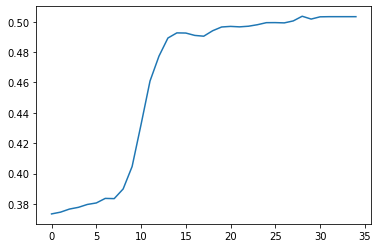

In [956]:
corrs = []
for i in range(len(Ws3)):
    P3_i, r = debias.debias_by_specific_directions(Ws3[:i+1], input_dim=300)
    df, cor = measure_emb_correlation(df_simlex, words, P3_i, i)
    corrs.append(cor)
plt.plot(corrs)

In [ ]:
for i in range(len(rowspace_projs_means_3)):
    P_i = debias.get_projection_to_intersection_of_nullspaces(rowspace_projs_means_3[:i+1], input_dim=300)
    measure_emb_correlation(df_simlex, words, P_i, i)

In [ ]:
for i in range(int(len(row_projs_random)/2)):
    P3_i = debias.get_projection_to_intersection_of_nullspaces(row_projs_random[:int(2*i)], input_dim=300)
    measure_emb_correlation(df_simlex, words, P3_i, i)

### Find Tukey median of Fem and Masc words

In [ ]:
sys.path.append("../")
from tukey_median import TukeyMedian
def data_preparation_tukey_median(vecs, d=302, L=3):
        d = 302 # d-way tree
        L = 3 # number of levels
        leaves = d**(L-1)
        vecs_padding = [v for v in vecs]
        random.shuffle(vecs_padding)
        while len(vecs_padding) < leaves:
                vecs_padding.extend(vecs_padding)
        return vecs_padding[:leaves]


In [50]:
d, L = 302, 3
fem_padded = data_preparation_tukey_median(fem_train)
masc_padded = data_preparation_tukey_median(masc_train)
neut_padded = data_preparation_tukey_median(neut_train)


In [54]:
fem_padded = data_preparation_tukey_median(fem_vecs)
masc_padded = data_preparation_tukey_median(masc_vecs)
neut_padded = data_preparation_tukey_median(neut_vecs)

In [55]:
fem_median = TukeyMedian(d, fem_padded, n_levels=L)
masc_median = TukeyMedian(d, masc_padded, n_levels=L)
neut_median = TukeyMedian(d, neut_padded, n_levels=L)


In [52]:
def get_projection_medians_onto_eachother(fem_median_point, masc_median_point, neut_median_point):
    # fem_median = TukeyMedian(d, fem_padded, n_levels=L)
    # masc_median = TukeyMedian(d, masc_padded, n_levels=L)
    # neut_median = TukeyMedian(d, neut_padded, n_levels=L)

    fem_median_point= fem_median.root.point
    masc_median_point= masc_median.root.point
    neut_median_point = neut_median.root.point

    v_median_1 = neut_median_point - masc_median_point
    v_median_2 = neut_median_point - fem_median_point

    W_median = [v_median_1, v_median_2]

    P, rowspace_projs = debias.debias_by_specific_directions(W_median, input_dim=300)
    return P



In [56]:
fem_median_point= fem_median.root.point
masc_median_point= masc_median.root.point
neut_median_point = neut_median.root.point

P_median = get_projection_medians_onto_eachother(fem_median_point, masc_median_point, neut_median_point)
X_dev_cleaned_med = P_median.dot(X_dev.T).T
X_train_cleaned_med = P_median.dot(X_train.T).T
X_test_cleaned_med = P_median.dot(X_test.T).T

linear_clf = LinearSVC(dual=False, max_iter = 1500)
linear_clf.fit(X_train_cleaned_med, Y_train)
acc_tukey_median = linear_clf.score(X_dev_cleaned_med, Y_dev)
print(f"The accuracy of Linear SVC after projecting tukey median approximations on top of each other is {round(acc_tukey_median*100, 2)}%.")

The accuracy of Linear SVC after projecting tukey median approximations on top of each other is 35.18%.


In [19]:
clf = LinearSVC(**params)
clf.fit(X_train, Y_train)
score = clf.score(X_dev, Y_dev)
print(f"The acuracy of Linear SVC before projection is {score * 100}%")

The acuracy of Linear SVC before projection is 100.0%


### Save the median points together with the fem and masc vecs

In [36]:
# The first vector is the median in both median_fem.npy and median_masc.npy
fem_with_median = np.concatenate((fem_median_point,fem_x), axis=0)
masc_with_median = np.concatenate((masc_median_point,masc_x), axis=0)
np.save("median_fem.npy", fem_median_point)
np.save("median_masc.npy", masc_median_point)

### Compare before and after projection by mean

In [ ]:
"""
nonlinear_clf = SVC(kernel = "rbf")
print("Before, rbf-svm:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

""" 

X_trained_cleaned = X_train_cleaned_mean
X_test_cleaned = X_test_cleaned_mean

print("Before, linear:")
linear_clf = LinearSVC(dual=False, max_iter = 1500)
linear_clf.fit(X_train, Y_train)
print(linear_clf.score(X_test, Y_test))

print("After mean projection, linear:")
linear_clf = LinearSVC(dual=False, max_iter = 1500)
linear_clf.fit(X_trained_cleaned, Y_train)
print(linear_clf.score(X_test_cleaned, Y_test))

print("After mean projection, rbf-svm:")
nonlinear_clf = SVC(kernel = "rbf")
nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

print("After mean projection, mlp:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))


### Compare before and after projection by median

In [47]:
"""
nonlinear_clf = SVC(kernel = "rbf")
print("Before, rbf-svm:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

""" 

X_trained_cleaned = X_train_cleaned_med
X_test_cleaned = X_test_cleaned_med

print("Before, linear:")
linear_clf = LinearSVC(dual=False, max_iter = 1500)
linear_clf.fit(X_train, Y_train)
print(linear_clf.score(X_test, Y_test))

print("After median projection, linear:")
linear_clf = LinearSVC(dual=False, max_iter = 1500)
linear_clf.fit(X_trained_cleaned, Y_train)
print(linear_clf.score(X_test_cleaned, Y_test))

print("After median projection, rbf-svm:")
nonlinear_clf = SVC(kernel = "rbf")
nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

print("After median projection, mlp:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))


Before, linear:
1.0
After mean projection, linear:
0.5151111111111111
After mean projection, rbf-svm:
0.9707936507936508
After mean projection, mlp:
0.9701587301587301


### Compare with debiasing on specific directions

In [64]:
specific_words = ["woman", "man"], ["girl", "boy"], ["she", "he"], ["mother", "father"], ["daughter", "son"], ["gal", "guy"], ["female", "male"], ["her", "his"], ["herself", "himself"], ["mary", "john"]
vecs_specific_words = np.array([ [model[p[1]] - model[p[0]]] for p in specific_words])
P_by_words, rowspace_projs = debias.debias_by_specific_directions(vecs_specific_words, 300) # projection matrix generated by zeroing the above directions
X_dev_cleaned = (P_by_words.dot(X_dev.T)).T
X_train_cleaned = (P_by_words.dot(X_train.T)).T

In [65]:
clf = LinearSVC(dual = False)
clf.fit(X_train_cleaned, Y_train)
print(clf.score(X_dev_cleaned, Y_dev))

0.8149206349206349


In [305]:
vecs_mean_cleaned = (P_mean_3.dot(vecs.T)).T
save_in_word2vec_format(vecs_mean_cleaned, words, "../better_proj_data/embeddings/vecs_mean.150k.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../better_proj_data/embeddings/vecs_mean.150k.cleaned.txt")

In [138]:
vecs_mixed_cleaned = (P_mp_inlp_2.dot(vecs.T)).T
save_in_word2vec_format(vecs_mixed_cleaned, words, "../better_proj_data/embeddings/vecs_mp_inlp_projection.150k.cleaned.txt")
model_cleaned_mixed, _, _ = load_word_vectors(fname = "../better_proj_data/embeddings/vecs_mp_inlp_projection.150k.cleaned.txt")

### Single projection of means with 3 classes

In [15]:
vecs_mean_cleaned = (P3_means_one.dot(vecs.T)).T
save_in_word2vec_format(vecs_mean_cleaned, words, "../better_proj_data/embeddings/vecs_mean_single_projection.150k.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../better_proj_data/embeddings/vecs_mean_single_projection.150k.cleaned.txt")

In [25]:
model_cleaned.most_similar("ariel", topn=10)

[('israel', 0.40791332721710205),
 ('israeli', 0.4049580693244934),
 ('gaza', 0.37858617305755615),
 ('sharon', 0.37806081771850586),
 ('aurora', 0.37187254428863525),
 ('aladdin', 0.3660593330860138),
 ('disney', 0.3623017966747284),
 ('ehud', 0.3605354428291321),
 ('hanna', 0.36014124751091003),
 ('triton', 0.35608813166618347)]

### Chose random words and get their neighbors before and after projection

In [22]:
import pickle
from collections import defaultdict

# words_chosen = np.random.choice(words[:15000] , size = 40)
words_chosen = ["boxing", "ts", "carolyn", "indicated", "russian", "tandem", "cigar", "autographed", "stack", "distressed", "sides", "masturbation", "them", "gently", "hogan", "eric", "maryland", "plus", "finale", "likelihood", "taiwan", "bent", "emirates", "rancho", "approaches", "amendments", "trainers", "ubuntu", "amount", "tiles", "upc", "job", "jpeg", "nevertheless", "lick", "critique", "weak", "subway", "hugs", "destination"]
random_words = ["order", "crack","craigslist", "populations", "epub",  "finals",  "installed",  "identifiable",  "photographs",  "ta",  "couch",  "cooler",  "becky",  "appreciated",  "negotiation",  "initial",  "chloe",  "filipino",  "relying",  "perpetual",  "himself",  "seaside",  "measure",  "yorkshire",  "merchandise",  "sub",  "tones",  "therapist",  "leaned",  "tho",  "lawyers",  "compile",  "chord",  "aims",  "ensure",  "aerospace",  "clubhouse",  "locking",  "reign",  "vulnerable"]
words_chosen = ["ruth", "charlotte", "abigail", "sophie", "nichole", "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia",
                "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike"]
topn = 3
words_before_and_after = defaultdict(dict)
gendered_words_before_and_after = defaultdict(dict)


# for w in words_chosen:
#     words_and_sims_before = model.most_similar(w, topn = topn)
#     words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
#     words_before, sims_before = zip(*words_and_sims_before)
#     words_after, sims_after = zip(*words__and_sims_after)
#     words_before_and_after[w]["before"] = words_before
#     words_before_and_after[w]["after"] = words_after
#     print("{} & {} & {} \\\\".format(w,words_before, words_after))
    


# for w in random_words:
#     words_and_sims_before = model.most_similar(w, topn = topn)
#     words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
#     words_before, sims_before = zip(*words_and_sims_before)
#     words_after, sims_after = zip(*words__and_sims_after)
#     words_before_and_after[w]["before"] = words_before
#     words_before_and_after[w]["after"] = words_after
#     print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
#     print("----------------------------------")

# print("====================================================================\n\n")
# print("gendered words:")
# words_chosen = ["miss", "mrs", "mr", "john", "rachel", "wife", "mom", "family", "father", "lady", "he", "she"]
# words_chosen = ["ruth", "charlotte", "abigail", "sophie", "nichole", "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia",
#                 "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike"]
# for w in words_chosen:
    
#     words_and_sims_before = model.most_similar(w, topn = topn)
#     words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
#     words_before, _ = zip(*words_and_sims_before)
#     words_after, _ = zip(*words__and_sims_after)
#     gendered_words_before_and_after[w]["before"] = words_before
#     gendered_words_before_and_after[w]["after"] = words_after
#     print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
#     print("----------------------------------")    
    
# with open("words_before_and_after.pickle", "wb") as f:
#     pickle.dump(words_before_and_after, f)
    
# with open("words_before_and_after_gendered.pickle", "wb") as f:
#     pickle.dump(gendered_words_before_and_after, f)



gendered words:
w: ruth
 most-similar-before: ('helen', 'esther', 'margaret')
 most-similar-after: ('esther', 'helen', 'margaret')
----------------------------------
w: charlotte
 most-similar-before: ('raleigh', 'nc', 'atlanta')
 most-similar-after: ('raleigh', 'nc', 'atlanta')
----------------------------------
w: abigail
 most-similar-before: ('hannah', 'lydia', 'eliza')
 most-similar-after: ('hannah', 'lydia', 'josiah')
----------------------------------
w: sophie
 most-similar-before: ('julia', 'marie', 'lucy')
 most-similar-after: ('claire', 'julia', 'madeleine')
----------------------------------
w: nichole
 most-similar-before: ('nicole', 'kimberly', 'kayla')
 most-similar-after: ('nicole', 'kimberly', 'mya')
----------------------------------
w: emma
 most-similar-before: ('emily', 'lucy', 'sarah')
 most-similar-after: ('emily', 'watson', 'sarah')
----------------------------------
w: olivia
 most-similar-before: ('emma', 'rachel', 'kate')
 most-similar-after: ('wilde', 'mun

### Bias by professions experiment

In [ ]:
model_cleaned_mp_neut, _, _ = load_word_vectors(fname = "../better_proj_data/embeddings/vecs_mean_neut.150k.cleaned_fixed.txt")

In [1128]:
def get_bias_by_neighbors(model, model_cleaned, gendered_words, v, gender_direction): 
    
    neighbors = model_cleaned.similar_by_vector(v, topn=100) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    # bias = np.sum([model.cosine_similarities(model[n], [gender_direction])[0] for n in neighbors_words])
    return bias

def bias_by_profession(model, model_cleaned, gender_direction, P, masc_words):
    
    with codecs.open("../data/lists/professions.json") as f:
        professions_and_scores = json.load(f)

    professions = [p[0] for p in professions_and_scores]
    #print(professions)
    professions = list(filter(lambda p: p in model, professions))
    vecs = np.array([model[p] for p in professions])
    vecs_cleaned = vecs.dot(P)
    # vecs_cleaned = np.array([model_cleaned[p] for p in professions])
    bias_vals = np.array([model.cosine_similarities(gender_direction,vecs)])[0]
    #bias_vals_after = np.array([model.cosine_similarities(gender_direction,vecs_cleaned)])[0]
    bias_by_neighbors_after = np.array([get_bias_by_neighbors(model, model_cleaned, masc_words, v, gender_direction) for v in vecs_cleaned])
    bias_by_neighbors_before = np.array([get_bias_by_neighbors(model, model, masc_words, v, gender_direction) for v in vecs])

    #plt.ylim([np.min(bias_vals), np.max(bias_vals)])
    plt.plot(bias_vals, bias_by_neighbors_after, marker = "o", linestyle = "none", color = "red", label = "after", alpha = 0.25)
    plt.plot(bias_vals, bias_by_neighbors_before, marker = "o", linestyle = "none", color = "blue", label = "before", alpha = 0.25)
    
    word_idx_high = np.argsort(bias_vals)[:4] 
    word_idx_low = np.argsort(bias_vals)[-4:]
    word_idx_middle_low = np.argsort(bias_vals)[-55:-51]
    word_idx_middle_high = np.argsort(bias_vals)[51:55]
    words_biased_fem = [professions[i] for i in word_idx_high]
    words_biased_masc = [professions[i] for i in word_idx_low]
    mid_low = [professions[i] for i in word_idx_middle_low]
    mid_high = [professions[i] for i in word_idx_middle_high]
    words = words_biased_masc + words_biased_fem + mid_low + mid_high
    
    for w in words:
        i = professions.index(w)
        x1,y1 = bias_vals[i],bias_by_neighbors_after[i]
        plt.annotate(w , (x1,y1), size = 8, color = "red")
        x2,y2 = bias_vals[i],bias_by_neighbors_before[i]
        plt.annotate(w, (x2,y2), size = 8, color = "blue")
        #plt.arrow(x2,y2,x1-x2,y1-y2, width = 0.0005)
        
    plt.legend()
    plt.xlabel("bias-by-PROJECTION of the professions before")
    plt.ylabel("bias-by-NEIGHBORS")
    plt.title("projection bias before vs. neighbors bias before/after \n(# neighbors closer to 'she' then 'he')")
    plt.show()
    
    print("Correlation before: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_before)))
    print("Correlation after: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_after)))

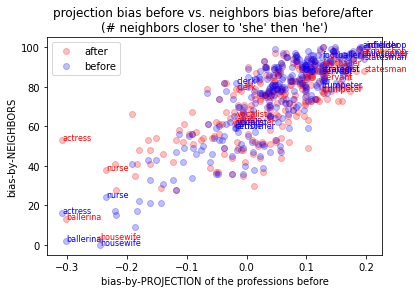

Correlation before: 0.852412527714236, p-value: 2.2680722096067284e-83
Correlation after: 0.745444221088338, p-value: 7.736886104423281e-53


In [1129]:
bias_by_profession(model, model_cleaned_neut, gender_direction, P_mean_3, None)

In [58]:
# get_bias_by_neighbors(model, model_cleaned, [], model["actress"].dot(P_means), gender_direction)
get_bias_by_neighbors(model, model_cleaned, [], model_cleaned, gender_direction)

46

### WEAT

In [802]:

import scipy
import scipy.misc as misc
import itertools


def project (ov, projection_vecs):
    v = ov.copy()
    for p in projection_vecs:
        p = p/np.linalg.norm(p)
        p = p.reshape((-1,))
        v = v - v.dot(p)*p
    return v

def s_word(w, A, B, model, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(model.similarity(w,a))
    for b in B:
        mean_b.append(model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, model, all_s_words):
    
    total = 0
    for x in X:
        x_sim = s_word(x, A, B, model, all_s_words)
        total += x_sim
    for y in Y:
        y_sim =  s_word(y, A, B, model, all_s_words)
        total -= y_sim
    
    #print(x_sim, y_sim)
        
    return total



def sim_word(w, A, B, model, P_):
    mean_a = []
    mean_b = []
    scale = 1
    w_cleaned = ((P_.dot(model[w].T)).T).reshape((1, -1))*scale
    for a in A:
        a_cleaned = (P_.dot(model[a].T)).T.reshape((1, -1))*scale
        mean_a.append(cosine_similarity(w_cleaned, a_cleaned))
    for b in B:
        b_cleaned = (P_.dot(model[b].T)).T.reshape((1, -1))*scale
        mean_b.append(cosine_similarity(w_cleaned, b_cleaned))
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    s = mean_a - mean_b

    return s


def sim_word_(w, A, B, model, vecs):
    mean_a = []
    mean_b = []
    w_cleaned = project(model[w], vecs).reshape((1,-1))
    for a in A:
        a_cleaned = project(model[a], vecs).reshape((1,-1))
        mean_a.append(cosine_similarity(w_cleaned, a_cleaned))
    for b in B:
        b_cleaned = project(model[b], vecs).reshape((1,-1))
        mean_b.append(cosine_similarity(w_cleaned, b_cleaned))
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    s = mean_a - mean_b

    return s
    

def weat_score(X, Y, A, B, model, P_):
    total = 0
    for x in X:
        x_sim = sim_word(x, A, B, model, P_)
        total += x_sim
    for y in Y:
        y_sim =  sim_word(y, A, B, model, P_)
        total -= y_sim
    return total[0][0]

def p_value_exhust(X, Y, A, B, model):
    
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, model, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    other_associations = []
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    for subset in tqdm.tqdm_notebook(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        s = s_group(Xi, Yi, A, B, model, all_s_words)
        other_associations.append(s)
        if s > s_orig:
            larger += 1
    #print ('num of samples', total)
    return larger/float(total), s_orig, other_associations


def p_value_sample(X, Y, A, B, model):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, model, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [61]:
#Load cleaned model (mean projected)
model_cleaned_mean, _, _ = load_word_vectors(fname = "../better_proj_data/embeddings/vecs_mean_neut.150k.cleaned.txt")

In [62]:
vecs_cleaned = (P3.dot(vecs.T)).T
save_in_word2vec_format(vecs_cleaned, words, "../data/embeddings/vecs.150k.cleaned_n=35.threeclasses.txt")
model_cleaned_inlp, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.150k.cleaned_n=35.threeclasses.txt")

### WEAT TEST SETS

In [663]:
vs = np.array(W3_means_one).squeeze(axis=1)

In [665]:
p_new = debias.get_rowspace_projection(vs)
p_new = np.eye(300) - p_new

In [52]:
A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

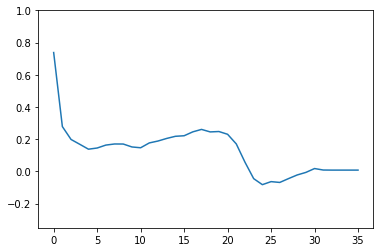

In [1272]:
weats1 = []
for i in range(len(Ws3)):
    # P3_i = debias.get_projection_to_intersection_of_nullspaces(rowspace_projs3[:i+1], input_dim=300)
    P3_j, rsp = debias.debias_by_specific_directions(Ws3[:i], input_dim=300)
    weats1.append(weat_score(A, B, C, D, model, P3_j))
plt.plot(list(range(len(Ws3))), weats1)
plt.ylim((-0.35, 1))
plt.show()


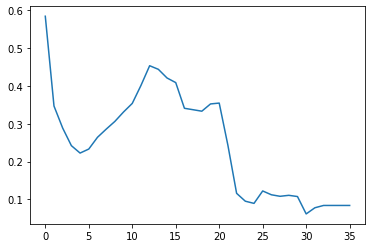

In [1273]:
weats2 = []
for i in range(len(Ws3)):
    # P3_i = debias.get_projection_to_intersection_of_nullspaces(rowspace_projs3[:i+1], input_dim=300)
    P3_j, rsp = debias.debias_by_specific_directions(Ws3[:i], input_dim=300)
    weats2.append(weat_score(A, B, E, F, model, P3_j))
plt.plot(list(range(len(Ws3))), weats2)
# plt.ylim((-0.35, 0.5))
plt.show()

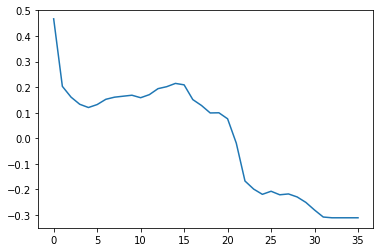

In [1274]:
weats3 = []
for i in range(len(Ws3)):
    # P3_i = debias.get_projection_to_intersection_of_nullspaces(rowspace_projs3[:i+1], input_dim=300)
    P3_j, rsp = debias.debias_by_specific_directions(Ws3[:i], input_dim=300)
    weats3.append(weat_score(A, B, G, H, model, P3_j))
plt.plot(list(range(len(Ws3))), weats3)
plt.ylim((-0.35, 0.5))
plt.show()


### WEAT MP + Random INLP

In [912]:
sys.path.append("../nullitoutsrc")
import debias_original
reload(debias)

<module 'debias' from '../nullitoutsrc\\debias.py'>

In [927]:
X3_train_cleaned_MP = (p_new.dot(X3_train.T)).T
Y3_train_shuffled = Y3_train.copy()
Y3_dev_shuffled = Y3_dev.copy()
shuffle(Y3_train_shuffled)
shuffle(Y3_dev_shuffled)
gender_clf = LinearSVC

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc

n = 33
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P_mp_random_inlp_3, rowspace_projs_mp_random_3, Ws_mp_random_3, accs3 = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X3_train_cleaned_MP, Y3_train_shuffled, X3_dev, Y3_dev_shuffled,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 32, accuracy: 0.3344169917641959: 100%|██████████| 33/33 [00:31<00:00,  1.04it/s] 


In [928]:
X3_train_cleaned_MP = (p_new.dot(X3_train.T)).T
Y3_train_shuffled = Y3_train.copy()
Y3_dev_shuffled = Y3_dev.copy()
shuffle(Y3_train_shuffled)
shuffle(Y3_dev_shuffled)
gender_clf = LinearSVC

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc

n = 33
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P_mp_random_inlp_o, rowspace_projs_mp_random_o, Ws_mp_random_o, accs_o = debias_original.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X3_train_cleaned_MP, Y3_train_shuffled, X3_dev, Y3_dev_shuffled,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 32, accuracy: 0.31447767663632425: 100%|██████████| 33/33 [00:35<00:00,  1.06s/it]


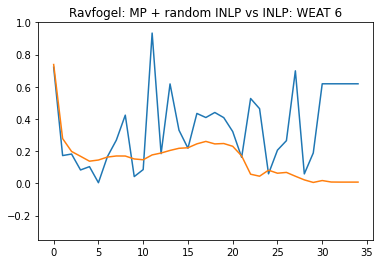

In [1026]:
weats1_r_o = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(Ws_mp_random_o[:35])
for i in range(len(Ws3)):
    P3_j, rsp = debias_original.debias_by_specific_directions(projection_vectors[:(i+1)], input_dim=300)
    weats1_r_o.append(weat_score(A, B, C, D, model, P3_j))
plt.plot(np.abs(weats1_r_o))
plt.plot(np.abs(weats1))
plt.ylim((-0.35, 1))
plt.title("Ravfogel: MP + random INLP vs INLP: WEAT 6")
plt.show()

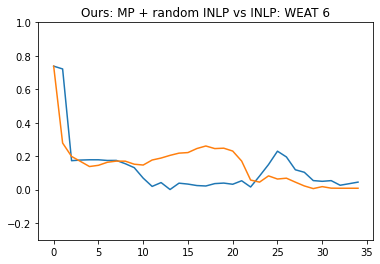

In [1023]:
weats1_r = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(Ws_mp_random_3[:35])
for i in range(len(Ws3)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats1_r.append(weat_score(A, B, C, D, model, P3_i))
plt.plot(np.abs(weats1_r))
plt.plot(np.abs(weats1))
plt.title("Ours: MP + random INLP vs INLP: WEAT 6")
plt.ylim((-0.3, 1))
plt.show()

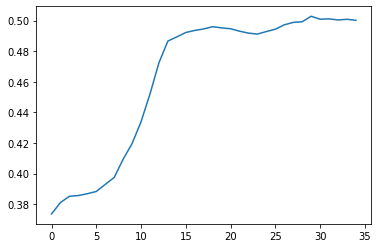

In [1106]:
corrs = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(Ws_mp_random_3[:35])
for i in range(len(projection_vectors)):
    P3_i, r = debias.debias_by_specific_directions(projection_vectors[:i+1], input_dim=300)
    df, cor = measure_emb_correlation(df_simlex, words, P3_i, i)
    corrs.append(cor)
plt.plot(corrs)

In [ ]:
sim_corrs = np.empty((0,35))
for s in simulations:
    corrs = []
    projection_vectors = []
    projection_vectors.extend(W3_means_one)
    projection_vectors.extend(s)
    for i in range(len(projection_vectors)):
        P3_i, r = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
        df, cor = measure_emb_correlation(df_simlex, words, P3_i, i)
        corrs.append(cor)
    sim_corrs = np.vstack((sim_corrs, corrs))

In [1116]:
corrs = []
for s in simulations:
    projection_vectors = []
    projection_vectors.extend(W3_means_one)
    projection_vectors.extend(s)
    P3_s, r = debias.debias_by_specific_directions(s+W3_means_one, input_dim=300)
    df, cor = measure_emb_correlation(df_simlex, words, P3_i, i)
    corrs.append(cor)

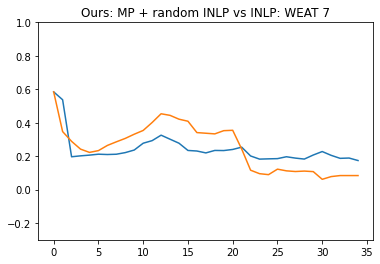

In [1004]:
weats2_r = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(Ws_mp_random_3)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats2_r.append(np.abs(weat_score(A, B, E, F, model, P3_i)))
plt.plot(np.abs(weats2_r))
plt.plot(np.abs(weats2))
plt.title("Ours: MP + random INLP vs INLP: WEAT 7")
plt.ylim((-0.3, 1))
plt.show()

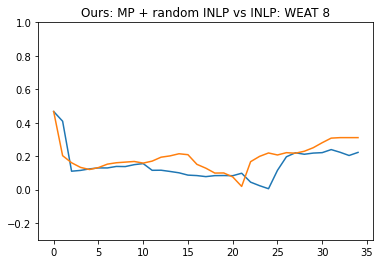

In [1005]:
weats3_r = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(Ws_mp_random_3)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats3_r.append((weat_score(A, B, G, H, model, P3_i)))
plt.plot(np.abs(weats3_r))
plt.plot(np.abs(weats3))
plt.title("Ours: MP + random INLP vs INLP: WEAT 8")
plt.ylim((-0.3, 1))
plt.show()

### WEAT MP + least significant components

In [731]:
print(weat_score(A, B, C, D, model, P_mp_least))
print(weat_score(A, B, E, F, model, P_mp_least))
print(weat_score(A, B, G, H, model, P_mp_least))

0.1867314913480937
0.21847345117278436
0.1310451893524014


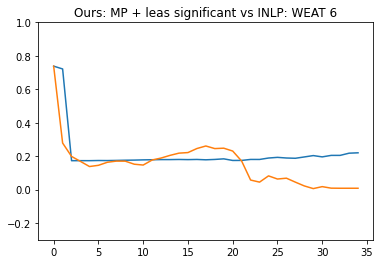

In [1050]:
weats1_l = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(least_significants)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats1_l.append(weat_score(A, B, C, D, model, P3_i))
plt.plot(np.abs(weats1_l))
plt.plot(np.abs(weats1))
plt.title("Ours: MP + leas significant vs INLP: WEAT 6")
plt.ylim((-0.3, 1))
plt.show()

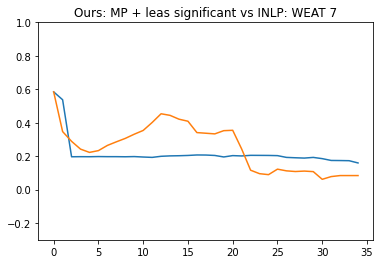

In [1051]:
weats2_l = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(least_significants)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats2_l.append(weat_score(A, B, E, F, model, P3_i))
plt.plot(np.abs(weats2_l))
plt.plot(np.abs(weats2))
plt.title("Ours: MP + leas significant vs INLP: WEAT 7")
plt.ylim((-0.3, 1))
plt.show()

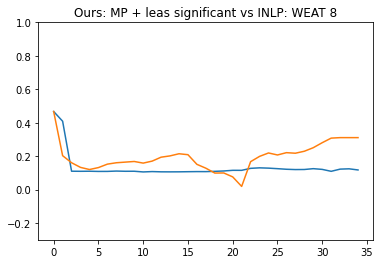

In [1052]:
weats3_l = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(least_significants)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats3_l.append(weat_score(A, B, G, H, model, P3_i))
plt.plot(np.abs(weats3_l))
plt.plot(np.abs(weats3))
plt.title("Ours: MP + leas significant vs INLP: WEAT 8")
plt.ylim((-0.3, 1))
plt.show()

### WEAT MP + most significant

In [481]:
print(weat_score(A, B, C, D, model, P_mp_most))
print(weat_score(A, B, E, F, model, P_mp_most))
print(weat_score(A, B, G, H, model, P_mp_most))

0.7381338734664441
0.5843410654026185
0.4669652868247327


In [1124]:
P_mp_most, rsp = debias.debias_by_specific_directions(W3_means_one+most_significants, input_dim=300)
df, cor = measure_emb_correlation(df_simlex, words, P_mp_most, i)
print(cor)

0.5022228263097063


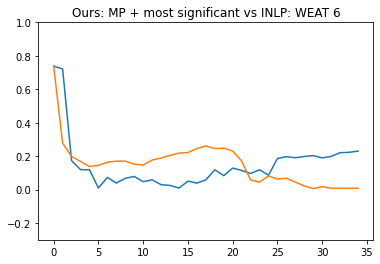

In [1053]:
weats1_m = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(most_significants)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats1_m.append(weat_score(A, B, C, D, model, P3_i))
plt.plot(np.abs(weats1_m))
plt.plot(np.abs(weats1))
plt.title("Ours: MP + most significant vs INLP: WEAT 6")
plt.ylim((-0.3, 1))
plt.show()

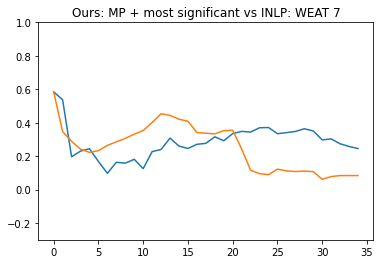

In [1054]:
weats2_m = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(most_significants)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats2_m.append(weat_score(A, B, E, F, model, P3_i))
plt.plot(np.abs(weats2_m))
plt.plot(np.abs(weats2))
plt.title("Ours: MP + most significant vs INLP: WEAT 7")
plt.ylim((-0.3, 1))
plt.show()

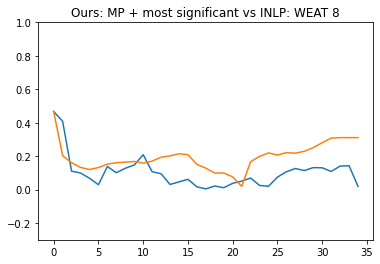

In [1055]:
weats3_m = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(most_significants)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats3_m.append(weat_score(A, B, G, H, model, P3_i))
plt.plot(np.abs(weats3_m))
plt.plot(np.abs(weats3))
plt.title("Ours: MP + most significant vs INLP: WEAT 8")
plt.ylim((-0.3, 1))
plt.show()

### WEAT MP + random vector

In [1160]:
def get_random_direction(pca):
    v3 = np.empty((0,300), dtype="float32")
    for j in range(3):
        v = np.zeros((1,300), dtype="float32")
        for c , e in zip(pca.components_, pca.explained_variance_):
            d = np.random.normal(0, 1)
            v = v + (d*c) * (e.reshape((1,-1)))
        v3 = np.vstack((v3, v))
    return v3

#### Generating random vectors

In [1363]:
def generate_random_vectors(runs, iters, pca):
    vectors = []
    for j in range(runs):
        r = []
        for i in range(iters):
            r.append(get_random_direction(pca))
        vectors.append(r)
    return vectors


In [1368]:
sim = generate_random_vectors(500, 34, pca)

In [1547]:
pca_nlp = PCA(300)
P3_8, rsp = debias.debias_by_specific_directions(Ws3[:8], input_dim=300)
pca_nlp.fit(P3_8.dot((X3_train.T)).T)
sim_nlp = generate_random_vectors(500, 27, pca)

In [1168]:
w1 = np.empty((0, 33), dtype= "float32")
w2 = np.empty((0, 33), dtype= "float32")
w3 = np.empty((0, 33), dtype= "float32")

simulations = []
for j in range(500):
    r = []
    temp1 = []
    temp2 = []
    temp3 = []
    for i in range(33):
        x = get_random_direction(pca)
        r.append(x)
        P3_i, rsp = debias.debias_by_specific_directions(W3_means_one+r, input_dim=300)
        temp1.append(weat_score(A, B, C, D, model, P3_i))
        temp2.append(weat_score(A, B, E, F, model, P3_i))
        temp3.append(weat_score(A, B, G, H, model, P3_i))
    w1 = np.vstack((w1, np.array(temp1)))
    w2 = np.vstack((w2, np.array(temp2)))
    w3 = np.vstack((w3, np.array(temp3)))
    simulations.append(r)

In [1237]:
# w1 = np.empty((0, 33), dtype= "float32")
# w2 = np.empty((0, 33), dtype= "float32")
# w3 = np.empty((0, 33), dtype= "float32")
temp1 = []
temp2 = []
temp3 = []

for j in range(500):
    x = get_random_direction(pca)
    simulations[j].append(x)
    P3_i, rsp = debias.debias_by_specific_directions(W3_means_one+simulations[j], input_dim=300)
    temp1.append(weat_score(A, B, C, D, model, P3_i))
    temp2.append(weat_score(A, B, E, F, model, P3_i))
    temp3.append(weat_score(A, B, G, H, model, P3_i))
    

In [1244]:
w1 = np.hstack((np.array([[weats1_l[0],  weats1_l[2]]] * 500), w1))
w2 = np.hstack((np.array([[weats2_l[0],  weats2_l[2]]] * 500), w2))
w3 = np.hstack((np.array([[weats3_l[0],  weats3_l[2]]] * 500), w3))

In [1326]:
np.save('weat6_INLP.npy', np.array(weats1))
np.save('weat7_INLP.npy', np.array(weats2))
np.save('weat8_INLP.npy', np.array(weats3))

In [1325]:
np.save('weat6_500_random_pca_vectors.npy', w1)
np.save('weat7_500_random_pca_vectors.npy', w2)
np.save('weat8_500_random_pca_vectors.npy', w3)

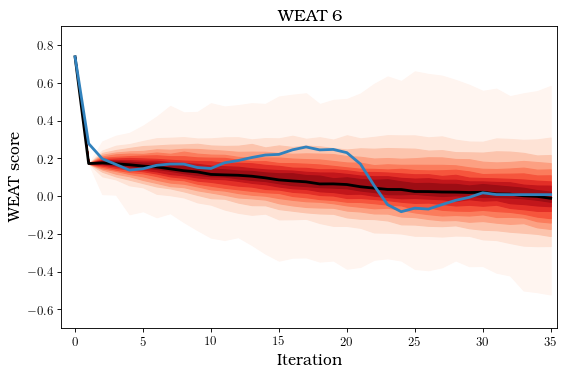

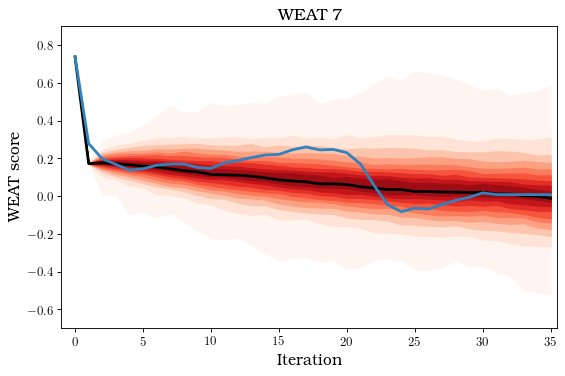

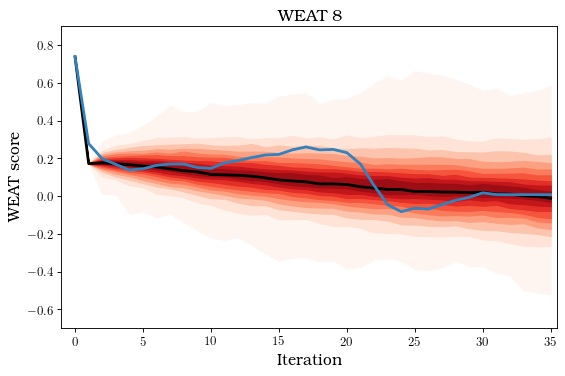

In [1492]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def draw_weat_mp_random_vs_inlp(mp_rand_res, inlp_res, weat_n, n = 20, z = 36, colormap = cm.Reds):
    n = 20 # change this value for the number of iterations/percentiles
    colormap = cm.Reds # change this for the colormap of choice
    percentiles = np.linspace(0,100,n)

    SampleData= w1.T
    # z = 36
    SDist=np.zeros((z,n))
    for i in range(n):
        for t in range(z):
            SDist[t,i]=np.percentile(SampleData[t,:],percentiles[i])

    half = int((n-1)/2)

    fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,4))
    ax1.plot(np.arange(0,z,1), SDist[:,half],color='k', linewidth = 2.5)
    ax1.plot(weats1, color = "#3182bd", linewidth = 2.5)
    for i in range(half):
        ax1.fill_between(np.arange(0,z,1), SDist[:,i],SDist[:,-(i+1)],color=colormap(i/half))

    ax1.set_title(f"WEAT {weat_n}", fontsize=15)
    ax1.tick_params(labelsize=11.5)
    ax1.set_xlabel('Iteration', fontsize=14)
    ax1.set_ylabel('WEAT score', fontsize=14)
    ax1.set_ylim((-0.7, 0.9))
    ax1.set_xlim((-1, 35.5))
    fig.set_size_inches(8,5)
    # fig.tight_layout()
    plt.show()

draw_weat_mp_random_vs_inlp(w1, weats1, 6, n = 20, z = 36, colormap = cm.Reds)
draw_weat_mp_random_vs_inlp(w2, weats2, 7, n = 20, z = 36, colormap = cm.Reds)
draw_weat_mp_random_vs_inlp(w3, weats3, 8, n = 20, z = 36, colormap = cm.Reds)

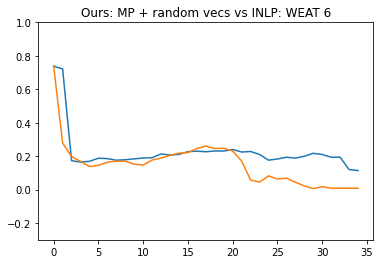

In [1066]:
weats1_rv = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(r)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats1_rv.append(weat_score(A, B, C, D, model, P3_i))
plt.plot(np.abs(weats1_rv))
plt.plot(np.abs(weats1))
plt.title("Ours: MP + random vecs vs INLP: WEAT 6")
plt.ylim((-0.3, 1))
plt.show()

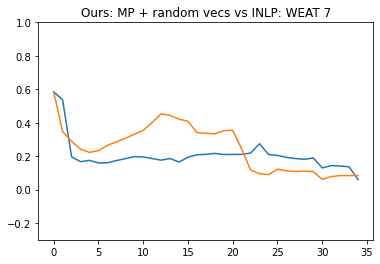

In [1067]:
weats2_rv = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(r)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats2_rv.append(weat_score(A, B, E, F, model, P3_i))
plt.plot(np.abs(weats2_rv))
plt.plot(np.abs(weats2))
plt.title("Ours: MP + random vecs vs INLP: WEAT 7")
plt.ylim((-0.3, 1))
plt.show()

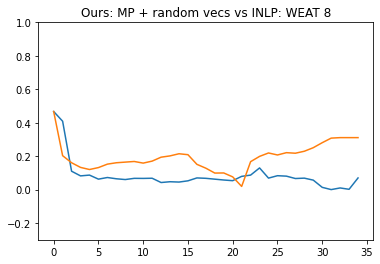

In [1068]:
weats3_rv = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(r)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats3_rv.append(weat_score(A, B, G, H, model, P3_i))
plt.plot(np.abs(weats3_rv))
plt.plot(np.abs(weats3))
plt.title("Ours: MP + random vecs vs INLP: WEAT 8")
plt.ylim((-0.3, 1))
plt.show()

### WEAT MP

In [573]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

w1 = weat_score(A, B, C, D, model, P3_means_one)
print ("Ex1: WEAT score: {} ".format(w1))


# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

w2 = weat_score(A, B, E, F, model, P3_means_one)
print ("Ex2: WEAT score: {} ".format(w2))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

w3 = weat_score(A, B, G, H, model, P3_means_one)
print ("Ex3: WEAT score: {} ".format(w3))

Ex1: WEAT score: 5.763368222921075 
Ex2: WEAT score: 5.261801541584413 
Ex3: WEAT score: 4.602921191159515 


In [442]:
np.linalg.norm(Ws3[0][0])

1.252126186615237

### WEAT INLP

In [554]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

w1 = weat_score(A, B, C, D, model, P3)
print ("Ex1: WEAT score: {} ".format(w1))

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

w2 = weat_score(A, B, E, F, model, P3)
print ("Ex2: WEAT score: {} ".format(w2))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

w3 = weat_score(A, B, G, H, model, P3)
print ("Ex3: WEAT score: {} ".format(w3))


Ex1: WEAT score: 1.2109364774436844 
Ex2: WEAT score: 1.1099101469792152 
Ex3: WEAT score: 1.0881722768984952 


### WEAT MP+INLP

In [163]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

p_value, association_score, others = p_value_exhust(A, B, C, D, model_cleaned_mixed)
print ("Ex1: WEAT score: {} with p-value {}".format(association_score, p_value))


# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

p_value, association_score, others = p_value_exhust(A, B, E, F, model_cleaned_mixed)
print ("Ex2: WEAT score: {} with p-value {}".format(association_score, p_value))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

p_value, association_score, others = p_value_exhust(A, B, G, H, model_cleaned_mixed)
print ("Ex3: WEAT score: {} with p-value {}".format(association_score, p_value))


d:\repos\linearGuarding\.venv\lib\site-packages\ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12870 [00:00<?, ?it/s]

Ex1: WEAT score: -0.030849015529383905 with p-value 0.5541569541569542


  0%|          | 0/12870 [00:00<?, ?it/s]

Ex2: WEAT score: 0.3451228376434301 with p-value 0.10512820512820513


  0%|          | 0/12870 [00:00<?, ?it/s]

Ex3: WEAT score: 0.05703266132331919 with p-value 0.37233877233877233


### WEAT MP+ random half

In [230]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

p_value, association_score, others = p_value_exhust(A, B, C, D, model_cleaned_mp_random_half)
print ("Ex1: WEAT score: {} with p-value {}".format(association_score, p_value))


# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

p_value, association_score, others = p_value_exhust(A, B, E, F, model_cleaned_mp_random_half)
print ("Ex2: WEAT score: {} with p-value {}".format(association_score, p_value))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

p_value, association_score, others = p_value_exhust(A, B, G, H, model_cleaned_mp_random_half)
print ("Ex3: WEAT score: {} with p-value {}".format(association_score, p_value))


d:\repos\linearGuarding\.venv\lib\site-packages\ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12870 [00:00<?, ?it/s]

Ex1: WEAT score: 0.27264655235921964 with p-value 0.061072261072261075


  0%|          | 0/12870 [00:00<?, ?it/s]

Ex2: WEAT score: 0.32383671536808833 with p-value 0.03341103341103341


  0%|          | 0/12870 [00:00<?, ?it/s]

Ex3: WEAT score: -0.003359488044225145 with p-value 0.5096348096348097


### Project the male and female mean to neutral mean

In [26]:
neut_mean = np.mean(neut_vecs, axis=0)
v2 = neut_mean - fem_mean
v3 = neut_mean - masc_mean
v2 = v2.reshape(1, -1)
v3 = v3.reshape(1, -1)
W_2 = [v2, v3]
P_means_neut, rowspace_projs = debias.debias_by_specific_directions(W_2, input_dim=300)

In [1126]:
vecs_means_neut_cleaned = (P_mean_3.dot(vecs.T)).T
save_in_word2vec_format(vecs_means_neut_cleaned, words, "../better_proj_data/embeddings/vecs_mean_neut.150k.cleaned.txt")
model_cleaned_neut, _, _ = load_word_vectors(fname = "../better_proj_data/embeddings/vecs_mean_neut.150k.cleaned.txt")

### Find better random directions

In [1144]:
pca = PCA(n_components=300)
pca.fit(P3_means_one.dot(X3_train.T).T)

pca_randoms = []
for i in range(34):
    v3 = np.empty((0,300), dtype="float32")
    for j in range(3):
        v = np.zeros((1,300), dtype="float32")
        for c , e in zip(pca.components_, pca.explained_variance_):
            d = np.random.normal(0, 1)
            v = v + (d*c) * (e.reshape((1,-1)))
        v3 = np.vstack((v3, v))
    pca_randoms.append(v3)



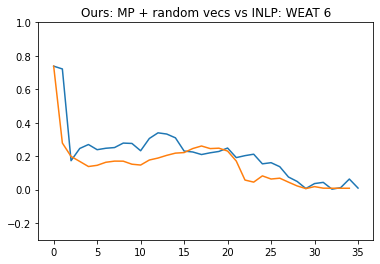

In [1145]:
weats1_rv = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(pca_randoms)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats1_rv.append(weat_score(A, B, C, D, model, P3_i))
plt.plot(np.abs(weats1_rv))
plt.plot(np.abs(weats1))
plt.title("Ours: MP + random vecs vs INLP: WEAT 6")
plt.ylim((-0.3, 1))
plt.show()

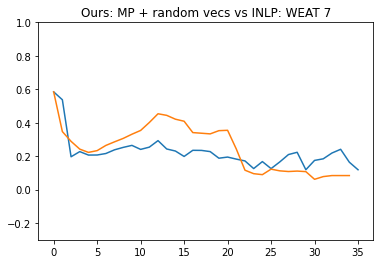

In [1146]:
weats2_rv = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(pca_randoms)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats2_rv.append(weat_score(A, B, E, F, model, P3_i))
plt.plot(np.abs(weats2_rv))
plt.plot(np.abs(weats2))
plt.title("Ours: MP + random vecs vs INLP: WEAT 7")
plt.ylim((-0.3, 1))
plt.show()

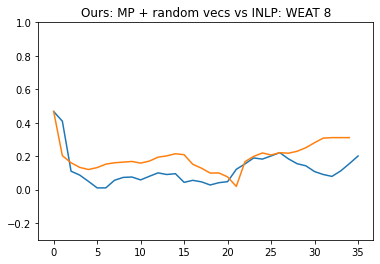

In [1147]:
weats3_rv = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(pca_randoms)
for i in range(len(projection_vectors)):
    P3_i, rsp = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    weats3_rv.append(weat_score(A, B, G, H, model, P3_i))
plt.plot(np.abs(weats3_rv))
plt.plot(np.abs(weats3))
plt.title("Ours: MP + random vecs vs INLP: WEAT 8")
plt.ylim((-0.3, 1))
plt.show()

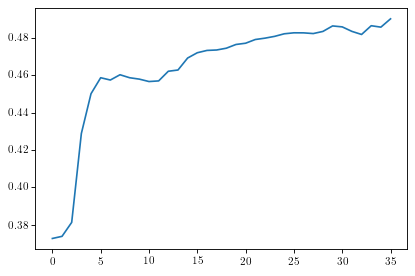

In [1371]:
corrs = []
projection_vectors = []
projection_vectors.extend(W3_means_one)
projection_vectors.extend(sim[0])
for i in range(len(projection_vectors)):
    P3_i, r = debias.debias_by_specific_directions(projection_vectors[:i], input_dim=300)
    df, cor = measure_emb_correlation(df_simlex, words, P3_i, i)
    corrs.append(cor)
plt.plot(corrs)

In [1407]:
corrs_random = []
for s in sim:
    P_i, r = debias.debias_by_specific_directions(s, input_dim=300)
    df, cor = measure_emb_correlation(df_simlex, words, P_i, i)
    corrs_random.append(cor)

In [1403]:
np.percentile(corrs, (5,95))

array([0.46264465, 0.49374888])

In [1419]:
np.percentile(corrs, (2.5,97.5))

array([0.45987831, 0.49757402])

In [1420]:
print(np.mean(corrs), np.std(corrs))

0.4783874586518231 0.009486742704517577


In [1408]:
np.percentile(corrs_random, (5,95))

array([0.43359477, 0.46137166])

In [1502]:
print(np.mean(corrs_random), np.std(corrs_random))

0.4471905781420855 0.008682391548212372


### INLP 8 iters + Random Projections

In [1458]:
w1_inlp_random = np.empty((0, 34), dtype= "float64")
w2_inlp_random = np.empty((0, 34), dtype= "float64")
w3_inlp_random = np.empty((0, 34), dtype= "float64")

for j in range(500):
    temp1 = []
    temp2 = []
    temp3 = []
    r = sim[j]
    for i in range(34):
        P3_i, rsp = debias.debias_by_specific_directions(Ws3[:9] + r[:i], input_dim=300)
        temp1.append(weat_score(A, B, C, D, model, P3_i))
        temp2.append(weat_score(A, B, E, F, model, P3_i))
        temp3.append(weat_score(A, B, G, H, model, P3_i))
    w1_inlp_random = np.vstack((w1_inlp_random, np.array(temp1)))
    w2_inlp_random = np.vstack((w2_inlp_random, np.array(temp2)))
    w3_inlp_random = np.vstack((w3_inlp_random, np.array(temp3)))

In [1487]:
w3_inlp_random = np.hstack((np.array([weats3[:8]]* 500), w3_inlp_random))

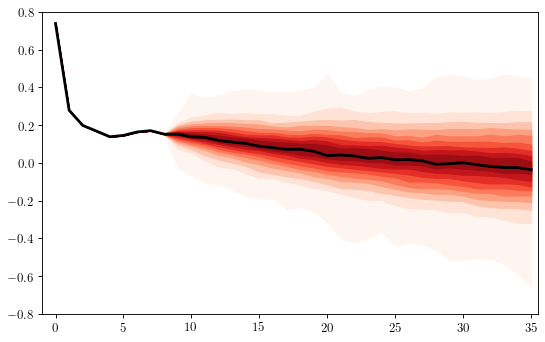

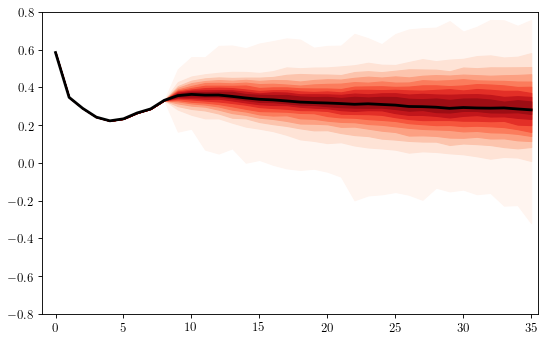

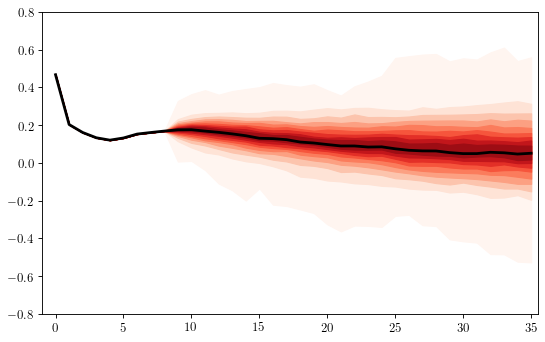

In [1552]:
def draw_comparison_with_random(mp_res, inlp_res, weat_n, n = 20, colormap = cm.Reds, z= 36):
    # n = 20 # change this value for the number of iterations/percentiles
    # colormap = cm.Reds # change this for the colormap of choice
    percentiles = np.linspace(0,100,n)

    SampleData= inlp_res.T
    # z = 36
    SDist=np.zeros((z,n))
    for i in range(n):
        for t in range(z):
            SDist[t,i]=np.percentile(SampleData[t,:],percentiles[i])

    half = int((n-1)/2)

    # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8,4))
    fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,4))
    ax1.plot(np.arange(0,z,1), SDist[:,half],color='k', linewidth = 2.5)
    # ax1.plot(weats1, color = "#3182bd", linewidth = 2.5)
    for i in range(half):
        ax1.fill_between(np.arange(0,z,1), SDist[:,i],SDist[:,-(i+1)],color=colormap(i/half))


    SampleData= mp_res.T
    z = 36
    SDist=np.zeros((z,n))
    for i in range(n):
        for t in range(z):
            SDist[t,i]=np.percentile(SampleData[t,:],percentiles[i])

    half = int((n-1)/2)
    # ax2.plot(np.arange(0,z,1), SDist[:,half],color='k', linewidth = 2.5)
    # ax1.plot(weats1, color = "#3182bd", linewidth = 2.5)
    # for i in range(half):
    #     ax2.fill_between(np.arange(0,z,1), SDist[:,i],SDist[:,-(i+1)],color=colormap(i/half))

    # ax1.plot([0,35], [0, 0], color= "green", linewidth=2)
    # ax2.plot([0,35], [0, 0], color= "green", linewidth=2)

    # ax1.set_ylabel(f"WEAT {weat_n}", fontsize=15)
    # ax2.set_ylabel(f"WEAT {weat_n}", fontsize=15)
    ax1.tick_params(labelsize=11.5)
    # ax2.tick_params(labelsize=11.5)
    # ax1.set_xlabel('Iteration', fontsize=14)
    # ax2.set_xlabel('Iteration', fontsize=14)
    # ax1.set_title('INLP 8 iters + Random vectors', fontsize=14)
    # ax2.set_title('MP + Random vectors', fontsize=14)
    ax1.set_ylim((-0.8, 0.8))
    ax1.set_xlim((-1, 35.5))
    # ax2.set_ylim((-0.8, 0.8))
    # ax2.set_xlim((-1, 35.5))
    fig.set_size_inches(8,5)
    plt.show()

draw_comparison_with_random(w1, w1_inlp_random, 6, n = 20, colormap = cm.Reds, z= 36)
draw_comparison_with_random(w2, w2_inlp_random, 7, n = 20, colormap = cm.Reds, z= 36)
draw_comparison_with_random(w3, w3_inlp_random, 8, n = 20, colormap = cm.Reds, z= 36)

### Only random projections

In [1421]:
w1_random = np.empty((0, 34), dtype= "float64")
w2_random = np.empty((0, 34), dtype= "float64")
w3_random = np.empty((0, 34), dtype= "float64")

for j in range(500):
    r = []
    temp1 = []
    temp2 = []
    temp3 = []
    r = sim[j]
    for i in range(34):
        P3_i, rsp = debias.debias_by_specific_directions(r[:i+1], input_dim=300)
        temp1.append(weat_score(A, B, C, D, model, P3_i))
        temp2.append(weat_score(A, B, E, F, model, P3_i))
        temp3.append(weat_score(A, B, G, H, model, P3_i))
    w1_random = np.vstack((w1_random, np.array(temp1)))
    w2_random = np.vstack((w2_random, np.array(temp2)))
    w3_random = np.vstack((w3_random, np.array(temp3)))

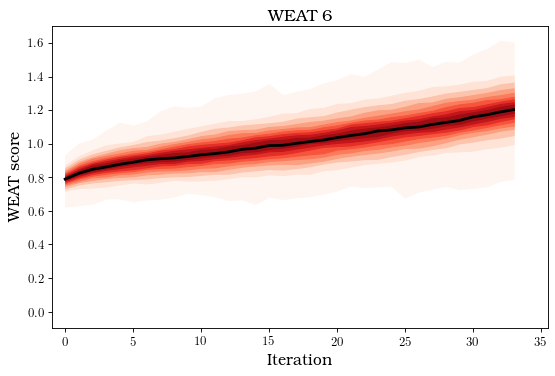

In [1587]:
n = 20 # change this value for the number of iterations/percentiles
colormap = cm.Reds # change this for the colormap of choice
percentiles = np.linspace(0,100,n)

SampleData= w1_random.T
z = 34
SDist=np.zeros((z,n))
for i in range(n):
    for t in range(z):
      SDist[t,i]=np.percentile(SampleData[t,:],percentiles[i])

half = int((n-1)/2)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,4))
ax1.plot(np.arange(0,z,1), SDist[:,half],color='k', linewidth = 2.5)
# ax1.plot(weats1, color = "#3182bd", linewidth = 2.5)
for i in range(half):
    ax1.fill_between(np.arange(0,z,1), SDist[:,i],SDist[:,-(i+1)],color=colormap(i/half))

ax1.set_title("WEAT 6", fontsize=15)
ax1.tick_params(labelsize=11.5)
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('WEAT score', fontsize=14)
ax1.set_ylim((-0.1, 1.7))
ax1.set_xlim((-1, 35.5))
fig.set_size_inches(8,5)
# fig.tight_layout()

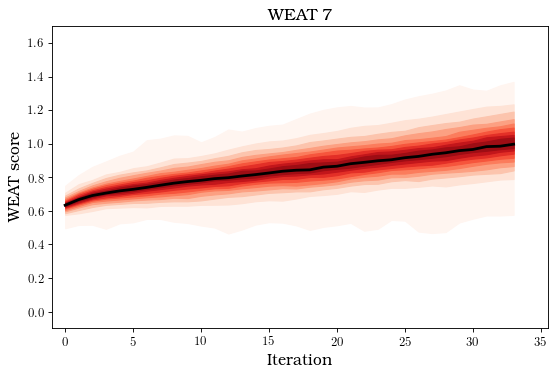

In [1585]:
n = 20 # change this value for the number of iterations/percentiles
colormap = cm.Reds # change this for the colormap of choice
percentiles = np.linspace(0,100,n)

SampleData= w2_random.T
z = 34
SDist=np.zeros((z,n))
for i in range(n):
    for t in range(z):
      SDist[t,i]=np.percentile(SampleData[t,:],percentiles[i])

half = int((n-1)/2)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,4))
ax1.plot(np.arange(0,z,1), SDist[:,half],color='k', linewidth = 2.5)
# ax1.plot(weats1, color = "#3182bd", linewidth = 2.5)
for i in range(half):
    ax1.fill_between(np.arange(0,z,1), SDist[:,i],SDist[:,-(i+1)],color=colormap(i/half))

ax1.set_title("WEAT 7", fontsize=15)
ax1.tick_params(labelsize=11.5)
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('WEAT score', fontsize=14)
ax1.set_ylim((-0.1, 1.7))
ax1.set_xlim((-1, 35.5))
fig.set_size_inches(8,5)
# fig.tight_layout()

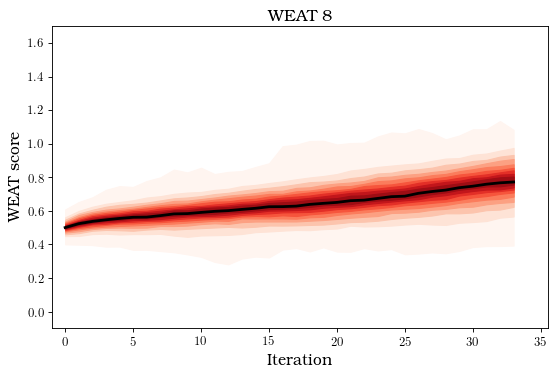

In [1586]:
n = 20 # change this value for the number of iterations/percentiles
colormap = cm.Reds # change this for the colormap of choice
percentiles = np.linspace(0,100,n)

SampleData= w3_random.T
z = 34
SDist=np.zeros((z,n))
for i in range(n):
    for t in range(z):
      SDist[t,i]=np.percentile(SampleData[t,:],percentiles[i])

half = int((n-1)/2)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,4))
ax1.plot(np.arange(0,z,1), SDist[:,half],color='k', linewidth = 2.5)
# ax1.plot(weats1, color = "#3182bd", linewidth = 2.5)
for i in range(half):
    ax1.fill_between(np.arange(0,z,1), SDist[:,i],SDist[:,-(i+1)],color=colormap(i/half))

ax1.set_title("WEAT 8", fontsize=15)
ax1.tick_params(labelsize=11.5)
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('WEAT score', fontsize=14)
ax1.set_ylim((-0.1, 1.7))
ax1.set_xlim((-1, 35.5))
fig.set_size_inches(8,5)
# fig.tight_layout()

In [1514]:
df_simlex

,word1,word2,POS,similarity,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex),glove_sim,proj_glove_sim
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41,0.569811,0.292754
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67,0.727013,0.635029
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19,0.668391,0.518292
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18,0.599539,0.481778
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93,0.578483,0.276759
...,...,...,...,...,...,...,...,...,...,...,...,...
994,join,acquire,V,2.85,2.86,2.93,2,0.00,0,0.99,0.350726,0.132630
995,send,attend,V,1.67,2.70,3.17,2,0.00,0,1.44,0.459770,0.218190
996,gather,attend,V,4.80,2.75,3.17,2,0.00,0,1.97,0.527741,0.439807
997,absorb,withdraw,V,2.97,3.11,3.04,2,0.00,0,1.75,0.263449,0.214523
